In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import glob
import random

In [21]:
file_path = "../Example_Data/hic.clean.1/hic.clean.csv.gz"
df = pd.read_csv(file_path)
df

,i1,j1,fq,pval,fdr,bon,ibp,jbp,rawc
0,31,60,0.195005,0.0,0.0,0.0,14875000,15020000,59.312878
1,32,36,0.998387,0.0,0.0,0.0,14880000,14900000,143.308880
2,33,37,0.998610,0.0,0.0,0.0,14885000,14905000,150.064740
3,105,121,0.405935,0.0,0.0,0.0,15245000,15325000,80.126940
4,105,122,0.313936,0.0,0.0,0.0,15245000,15330000,76.968880
...,...,...,...,...,...,...,...,...,...
17573,185,186,1.000000,1.0,1.0,1.0,15645000,15650000,295.092200
17574,185,187,1.000000,1.0,1.0,1.0,15645000,15655000,216.390900
17575,186,186,1.000000,1.0,1.0,1.0,15650000,15650000,1002.323000
17576,186,187,1.000000,1.0,1.0,1.0,15650000,15655000,368.787050


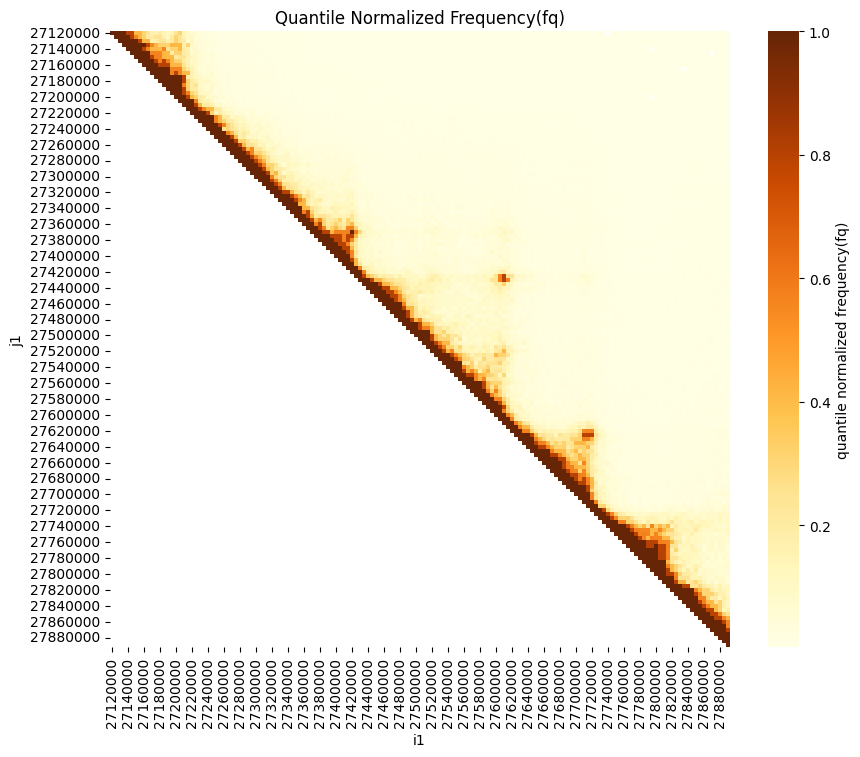

In [ ]:
pivot_table = df.pivot(index="ibp", columns="jbp", values="fq")

plt.figure(figsize=(10, 8))
sns.heatmap(
    pivot_table,
    fmt=".2f",
    cmap="YlOrBr",
    cbar_kws={"label": "quantile normalized frequency(fq)"},
)
plt.title("Quantile Normalized Frequency(fq)")
plt.xlabel("i1")
plt.ylabel("j1")
plt.show()

-------NEW---------


**Gene Data**


In [2]:
file_path = "../Data/ncbi_dataset.tsv"
gene_df = pd.read_csv(file_path, sep="\t")
gene_df = gene_df[["Gene ID", "Name", "Symbol", "Chromosome", "Begin", "End"]]
gene_df

,Gene ID,Name,Symbol,Chromosome,Begin,End
0,100287102,DEAD/H-box helicase 11 like 1 (pseudogene),DDX11L1,1,11874,14409
1,653635,"WASP family homolog 7, pseudogene",WASH7P,1,14362,29370
2,102466751,microRNA 6859-1,MIR6859-1,1,17369,17436
3,107985730,MIR1302-2 host gene,MIR1302-2HG,1,29774,35418
4,100302278,microRNA 1302-2,MIR1302-2,1,30366,30503
...,...,...,...,...,...,...
68320,100289087,testis specific protein Y-linked 10,TSPY10,Y,752540,755334
68321,642631,"testis specific protein Y-linked 15, pseudogene",TSPY15P,Y,772716,775527
68322,64593,RNA binding motif protein Y-linked family 3 me...,RBMY3AP,Y,835375,839807
68323,100874288,"testis specific protein Y-linked 25, pseudogene",TSPY25P,Y,848837,851006


In [ ]:
data_dir = "../Data/all_processed_HiC"
out_put_dir = "../Data/refined_processed_HiC"


files = [f for f in os.listdir(data_dir) if f.endswith(".csv.gz")]

for file in files:
    # cell line name
    cell_line = file.split("_")[0]

    file_path = os.path.join(data_dir, file)
    df = pd.read_csv(file_path)

    df = df.drop(columns=["rawc"])

    # get the first value of 'fq' and 'fdr' for each group
    df = df.groupby(["chr", "ibp", "jbp"], as_index=False).agg(
        {"fq": "first", "fdr": "first"}
    )

    df["cell_line"] = cell_line

    # save the processed HiC file
    processed_file_path = os.path.join(out_put_dir, f"{cell_line}_processed.csv.gz")
    df.to_csv(processed_file_path, index=False, compression="gzip")

In [8]:
file_path = "../Data/refined_processed_HiC/IMR_processed.csv.gz"
IMR_df = pd.read_csv(file_path)
print(len(IMR_df))
print(IMR_df.tail())

121150432
            chr        ibp        jbp   fq  fdr cell_line
121150427  chrX  154055000  154060000  1.0  1.0       IMR
121150428  chrX  154055000  154065000  1.0  1.0       IMR
121150429  chrX  154060000  154060000  1.0  1.0       IMR
121150430  chrX  154060000  154065000  1.0  1.0       IMR
121150431  chrX  154065000  154065000  1.0  1.0       IMR


**Get example data from the refined csv.gz, ramdomly get 3 chr from each file**


In [ ]:
def process_and_sample_data(input_folder, output_folder, sample_count=3):
    # Ensure output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Iterate over each .csv.gz file in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".csv.gz"):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            # Load the compressed CSV file
            df = pd.read_csv(input_path, compression="gzip")

            # Check if 'chr' column exists
            if "chr" not in df.columns:
                print(f"'chr' column not found in {filename}. Skipping this file.")
                continue

            # Get unique chromosome values and randomly select 3 of them
            unique_chromosomes = df["chr"].unique()
            if len(unique_chromosomes) < sample_count:
                print(f"Not enough unique chromosomes in {filename}. Skipping this file.")
                continue

            sampled_chromosomes = random.sample(list(unique_chromosomes), sample_count)

            # Filter the dataframe to include only the selected chromosomes
            sampled_data = df[df["chr"].isin(sampled_chromosomes)]

            # Save the sampled data to the output file in gzip format
            sampled_data.to_csv(output_path, index=False, compression="gzip")
            print(f"Processed and saved {filename} with {sample_count} random 'chr' groups to {output_folder}")


# Define your input and output folders
input_folder = "../Data/refined_processed_HiC"
output_folder = "../Example_Data/refined_processed_HiC"

# Run the function
process_and_sample_data(input_folder, output_folder)


Processed and saved IMR_processed.csv.gz with 3 random 'chr' groups to ../Example_Data/refined_processed_HiC
Processed and saved GM_processed.csv.gz with 3 random 'chr' groups to ../Example_Data/refined_processed_HiC
Processed and saved K_processed.csv.gz with 3 random 'chr' groups to ../Example_Data/refined_processed_HiC


**Get example data from the refined csv.gz, get 3 chrs from each file, these chrs exist in each file**

In [3]:
def process_and_sample_data(input_folder, output_folder, sample_count=2):
    # Ensure output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Collect the intersection of 'chr' values across all files
    common_chromosomes = None

    # First pass: Identify common 'chr' values
    for filename in os.listdir(input_folder):
        if filename.endswith(".csv.gz"):
            input_path = os.path.join(input_folder, filename)

            # Load the compressed CSV file
            df = pd.read_csv(input_path, compression="gzip")

            # Check if 'chr' column exists
            if "chr" not in df.columns:
                print(f"'chr' column not found in {filename}. Skipping this file.")
                continue

            # Update the set of common chromosomes
            file_chromosomes = set(df["chr"].unique())
            if common_chromosomes is None:
                common_chromosomes = file_chromosomes
            else:
                common_chromosomes &= file_chromosomes

    # Check if we have enough common chromosomes
    if common_chromosomes is None or len(common_chromosomes) < sample_count:
        print(f"Not enough common chromosomes across all files. Process aborted.")
        return

    # Randomly select the required number of common chromosomes
    sampled_chromosomes = random.sample(common_chromosomes, sample_count)
    print(f"Sampled chromosomes: {sampled_chromosomes}")

    # Second pass: Process each file with the sampled chromosomes
    for filename in os.listdir(input_folder):
        if filename.endswith(".csv.gz"):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            # Load the compressed CSV file
            df = pd.read_csv(input_path, compression="gzip")

            # Filter the dataframe to include only the selected chromosomes
            sampled_data = df[df["chr"].isin(sampled_chromosomes)]

            # Save the sampled data to the output file in gzip format
            sampled_data.to_csv(output_path, index=False, compression="gzip")
            print(f"Processed and saved {filename} with {sample_count} common 'chr' groups to {output_folder}")


# Define your input and output folders
input_folder = "../Data/refined_processed_HiC"
output_folder = "../Example_Data/refined_processed_HiC"

# Run the function
process_and_sample_data(input_folder, output_folder)


/var/folders/pm/_db3z8953vb1gtk99jkk_sb80000gn/T/ipykernel_75848/2276497908.py:34: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_chromosomes = random.sample(common_chromosomes, sample_count)


Sampled chromosomes: ['chr17', 'chr12']
Processed and saved IMR_processed.csv.gz with 2 common 'chr' groups to ../Example_Data/refined_processed_HiC
Processed and saved GM_processed.csv.gz with 2 common 'chr' groups to ../Example_Data/refined_processed_HiC
Processed and saved K_processed.csv.gz with 2 common 'chr' groups to ../Example_Data/refined_processed_HiC


In [4]:
file_path = "../Example_Data/refined_processed_HiC/GM_processed.csv.gz"
IMR_Example_df = pd.read_csv(file_path)
print(len(IMR_Example_df))
IMR_Example_df

15826966


,chr,ibp,jbp,fq,fdr,cell_line
0,chr12,320000,320000,1.0,1.000000,GM
1,chr12,320000,325000,1.0,1.000000,GM
2,chr12,320000,330000,1.0,1.000000,GM
3,chr12,320000,335000,1.0,0.482129,GM
4,chr12,320000,340000,1.0,0.000000,GM
...,...,...,...,...,...,...
15826961,chr17,82865000,82870000,1.0,1.000000,GM
15826962,chr17,82865000,82875000,1.0,1.000000,GM
15826963,chr17,82870000,82870000,1.0,1.000000,GM
15826964,chr17,82870000,82875000,1.0,1.000000,GM


**Find each cell line chromosome's range**


In [5]:
input_folder = "../Example_Data/refined_processed_HiC"
output_folder = "../Example_Data/seqs"

for filename in os.listdir(input_folder):
    if filename.endswith(".csv.gz"):
        # get cell_line name
        cell_line = filename.split("_")[0]

        file_path = os.path.join(input_folder, filename)
        df = pd.read_csv(file_path, compression="gzip")

        range_results = []

        # group by chromosome
        for chr_id, group in df.groupby("chr"):

            for _, row in group.iterrows():
                ibp_start = row["ibp"]
                ibp_end = ibp_start + 5000
                jbp_start = row["jbp"]
                jbp_end = jbp_start + 5000

                range_results.extend([
                    {
                        "cell_line": cell_line,
                        "chrID": chr_id,
                        "start_value": ibp_start,
                        "end_value": ibp_end,
                    },
                    {
                        "cell_line": cell_line,
                        "chrID": chr_id,
                        "start_value": jbp_start,
                        "end_value": jbp_end,
                    }
                ])

        # delete duplicates
        range_results = [dict(t) for t in {tuple(d.items()) for d in range_results}]

        merged_results = []
        range_results = sorted(range_results, key=lambda x: (x["chrID"], x["start_value"]))

        for entry in range_results:
            # if merged_results is empty or the end_value of the last entry is not equal to the start_value of the current
            if not merged_results or merged_results[-1]["chrID"] != entry["chrID"] or merged_results[-1]["end_value"] < entry["start_value"]:
                merged_results.append(entry)
            else:
                # merge adjacent ranges
                merged_results[-1]["end_value"] = max(merged_results[-1]["end_value"], entry["end_value"])

        # save
        result_df = pd.DataFrame(merged_results)
        output_filename = f"{cell_line}_ranges.csv.gz"
        output_path = os.path.join(output_folder, output_filename)
        result_df.to_csv(output_path, index=False, compression="gzip")

        print(f"Processed and saved: {output_filename}")

Processed and saved: IMR_ranges.csv.gz
Processed and saved: GM_ranges.csv.gz
Processed and saved: K_ranges.csv.gz


In [6]:
# file_path = "../Data/seqs/IMR_ranges.csv.gz"
file_path = "../Example_Data/seqs/K_ranges.csv.gz"
IMR_df = pd.read_csv(file_path)

print(f"Total rows: {len(IMR_df)}")
print(IMR_df)

equal_values_df = IMR_df[IMR_df["start_value"] == IMR_df["end_value"]]

print(f"Rows where start_value == end_value: {len(equal_values_df)}")

if len(equal_values_df) > 0:
    print("Rows where start_value == end_value:")
    print(equal_values_df)
else:
    print("No rows where start_value == end_value found.")


Total rows: 44
   cell_line  chrID  start_value  end_value
0          K  chr12       315000    8410000
1          K  chr12      8415000    8425000
2          K  chr12      8435000    9515000
3          K  chr12      9530000    9555000
4          K  chr12      9565000   11360000
5          K  chr12     11370000   11375000
6          K  chr12     11390000   34510000
7          K  chr12     39180000  132600000
8          K  chr17       605000   12450000
9          K  chr17     12455000   18460000
10         K  chr17     18465000   19155000
11         K  chr17     19160000   19165000
12         K  chr17     19180000   19190000
13         K  chr17     19205000   19215000
14         K  chr17     19220000   21800000
15         K  chr17     21810000   21905000
16         K  chr17     21920000   21925000
17         K  chr17     21930000   21955000
18         K  chr17     21965000   21995000
19         K  chr17     22040000   22520000
20         K  chr17     27085000   36380000
21         K  chr

In [35]:
# test running time
chromosome_dir = "../Example_Data/refined_processed_HiC"
batch_size = 5000  # Adjust batch size based on performance

# Loop through all files in the directory
for file_name in os.listdir(chromosome_dir):
    if file_name.endswith(".csv.gz"):
        # Get the cell_line from the file name
        cell_line = re.search(r"^(\w+)_", file_name).group(1)
        file_path = os.path.join(chromosome_dir, file_name)
        print(f"Processing {file_path}...")
        # Read the CSV file in chunks
        for chunk in pd.read_csv(
            file_path, usecols=["chr", "ibp", "jbp", "fq", "fdr"], chunksize=batch_size
        ):
            # Convert the chunk to a list of tuples
            non_random_hic_records = chunk[
                ["chr", "ibp", "jbp", "fq", "fdr"]
            ].values.tolist()

            # Prepare data for batch insertion
            data_to_insert = [
                (record[0], record[1], record[2], record[3], record[4])
                for record in non_random_hic_records
            ]

data_to_insert

Processing ../Example_Data/refined_processed_HiC/IMR_processed.csv.gz...
Processing ../Example_Data/refined_processed_HiC/GM_processed.csv.gz...
Processing ../Example_Data/refined_processed_HiC/K_processed.csv.gz...


[('chrX', 'K', 0.0041081123073418, 0.569710520196939, 112065000, 113040000),
 ('chrX', 'K', 0.0035810826372247, 0.628594499662182, 153225000, 153695000),
 ('chrX', 'K', 0.998513304064495, 1.0, 48515000, 48525000),
 ('chrX', 'K', 0.0036254066491494, 0.611712184135404, 41625000, 43160000),
 ('chrX', 'K', 0.0034671561411885, 0.526561461516448, 71420000, 72330000),
 ('chrX', 'K', 0.0188126467064574, 1.0, 77010000, 77115000),
 ('chrX', 'K', 0.0274665406249405, 0.439941868163353, 11240000, 11405000),
 ('chrX', 'K', 0.0033906999939055, 1.0, 78020000, 78170000),
 ('chrX', 'K', 0.0035998750595321, 0.612113457337415, 137270000, 139965000),
 ('chrX', 'K', 0.0119747199381353, 0.352620697704173, 10530000, 10935000),
 ('chrX', 'K', 0.0422167680080767, 0.50955046151329, 111385000, 111495000),
 ('chrX', 'K', 0.0193732390896355, 0.0044604516772379, 55220000, 55940000),
 ('chrX', 'K', 0.0055443813309996, 0.563409954724845, 21660000, 22125000),
 ('chrX', 'K', 0.0154909134192968, 0.711343988076662, 138200